In [39]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import models
from keras import layers
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import scikitplot as skplot
from SwarmPackagePy import ba

In [40]:
df = pd.read_csv('../Datasets/Final_Dataset.csv', index_col=[0])

In [41]:
df.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,gender,jaundice,PDD,Class/ASD,age_range_'12-16 years',age_range_'18 and more',age_range_'4-11 years'
0,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,1,0
1,1,1,0,1,0,0,0,1,0,1,1,0,1,0,0,1,0
2,1,1,0,1,1,0,1,1,1,1,1,1,1,1,0,1,0
3,1,1,0,1,0,0,1,1,0,1,0,0,1,0,0,1,0
4,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [42]:
df.shape

(1100, 17)

In [43]:
labels = df.pop('Class/ASD')
y = np.array(labels)

In [44]:
X = df.to_numpy()

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)

In [46]:
print(f'We have {X_train.shape[0]} train samples')
print(f'We have {X_test.shape[0]} test samples')

We have 880 train samples
We have 220 test samples


In [47]:
network = models.Sequential()
network.add(layers.Dense(units=32, activation='sigmoid', input_shape=(X_train.shape[1],)))
network.add(layers.Dense(units=32, activation='sigmoid'))
network.add(layers.Dense(units=1, activation='sigmoid'))

In [48]:
network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 1,633
Trainable params: 1,633
Non-trainable params: 0
_________________________________________________________________


In [49]:
def minimization_function(x):
#     print(len(x))
    layer1_weights = np.array(x[0:512]).reshape(16,32)
    layer1_biases = np.array(x[512:544])
    
    layer2_weights = np.array(x[544:1568]).reshape(32,32)
    layer2_biases = np.array(x[1568:1600])
    
    layer3_weights = np.array(x[1600:1632]).reshape(32,1)
    layer3_biases = np.array(x[1632:1633])
    
    network.layers[0].set_weights([layer1_weights, layer1_biases])
    network.layers[1].set_weights([layer2_weights, layer2_biases])
    network.layers[2].set_weights([layer3_weights, layer3_biases])
    
    cso_predict = network.predict(X_train)    
    return mean_squared_error(y_train, cso_predict)

In [58]:
swarm = ba(100, minimization_function, lb=-1, ub=1, dimension=1633, iteration=100, r0=0.9,
                 V0=0.5, fmin=0, fmax=0.02, alpha=0.9, csi=0.9)

In [59]:
best_solution = swarm.get_Gbest()

In [60]:
layer1_weights = np.array(best_solution[0:512]).reshape(16,32)
layer1_biases = np.array(best_solution[512:544])

layer2_weights = np.array(best_solution[544:1568]).reshape(32,32)
layer2_biases = np.array(best_solution[1568:1600])

layer3_weights = np.array(best_solution[1600:1632]).reshape(32,1)
layer3_biases = np.array(best_solution[1632:1633])

network.layers[0].set_weights([layer1_weights, layer1_biases])
network.layers[1].set_weights([layer2_weights, layer2_biases])
network.layers[2].set_weights([layer3_weights, layer3_biases])

In [61]:
predictions = network.predict(X_test)

In [62]:
predictions[predictions > 0.5] = 1
predictions[predictions < 0.5] = 0

In [63]:
print("--------------------- RESULTS OF BAT ALGORITHM -----------------------")
print("------------------------------------------------------------------------")
print("Accuracy Score: ", accuracy_score(y_test, predictions))
print("------------------------------------------------------------------------")
print("Mean Squared Error: ", mean_squared_error(y_test, predictions))
print("------------------------------------------------------------------------")
print("Confusion Matrix: \n\n",confusion_matrix(y_test, predictions))
print("------------------------------------------------------------------------")
print("Classification Report: \n\n",classification_report(y_test, predictions))
print("------------------------------------------------------------------------")

--------------------- RESULTS OF BAT ALGORITHM -----------------------
------------------------------------------------------------------------
Accuracy Score:  0.9272727272727272
------------------------------------------------------------------------
Mean Squared Error:  0.07272727272727272
------------------------------------------------------------------------
Confusion Matrix: 

 [[136   7]
 [  9  68]]
------------------------------------------------------------------------
Classification Report: 

               precision    recall  f1-score   support

           0       0.94      0.95      0.94       143
           1       0.91      0.88      0.89        77

    accuracy                           0.93       220
   macro avg       0.92      0.92      0.92       220
weighted avg       0.93      0.93      0.93       220

------------------------------------------------------------------------


In [64]:
iteration_mean = []
for i in range(len(swarm.get_agents())):
    agents_mean = []
    for j in range(len(swarm.get_agents()[i])):
        a_mse = minimization_function(swarm.get_agents()[i][j])
        agents_mean.append(a_mse)
    iteration_mean.append(np.mean(a_mse))

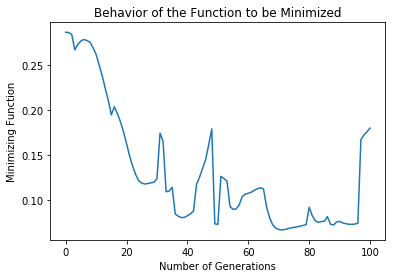

In [65]:
x1 = list(range(len(iteration_mean)))
plt.title('Behavior of the Function to be Minimized')
plt.xlabel('Number of Generations')
plt.ylabel('Minimizing Function')
plt.plot(x1, iteration_mean)
plt.show()